In [473]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from copy import deepcopy

from scipy import ndimage
from skimage.measure import label

from numpy import linalg
from scipy.sparse.linalg import eigs

from skimage.exposure import match_histograms


In [474]:
def segment_contour(img, contour):
    """
    Given an image and a contour from that image, 
    return a segementation of the pixels inside the contour
        and the mask of the contour pixels
    """
    box_min_x, box_min_y = contour.min(axis=0)[0]
    box_max_x, box_max_y = contour.max(axis=0)[0]

    x,y,w,h = cv2.boundingRect(contour)
    
    seg = np.ones(img.shape)*255
    mask = np.zeros(img.shape)
    mask = cv2.drawContours(mask, [contour], -1, (1,1,1), -1)
    seg[np.where(mask > 0)] = img[np.where(mask>0)]
    
    return seg.astype('uint8'), mask#[box_min_x:box_max_x, box_min_y:box_min_y]

In [493]:
DEBUG = False

scale_factor = 10
img_fps = sorted(glob('../2_live_bees/1_cards/*'))
#np.random.shuffle(img_fps)
reference = cv2.imread('../2_live_bees/reference_card_2024_06_13_h05b78.png')

for img_fp in tqdm(img_fps):

    if DEBUG:
        img_fp = '../2_live_bees/1_cards/2024_06_05_h01bee21.png'#img_fps[5]
    
    date = '_'.join(img_fp.split('/')[-1].split('_')[:-1])
    bee_id = img_fp.split('_')[-1].split('.')[0]
    
    img = cv2.imread(img_fp)

    matched = match_histograms(img, reference, channel_axis=-1)

    if DEBUG:
        plt.figure()
        plt.imshow(img)
        plt.title('img')
    if DEBUG:
        plt.figure()
        plt.imshow(matched)
        plt.title('histogram matched')
    
    crop_top = 30
    crop_bott = 30
    crop_right = 20
    crop_left = 5

    scaled_img = matched[::scale_factor,::scale_factor] # crude downsampling
    scaled_img = scaled_img[crop_top:scaled_img.shape[0] - crop_bott, crop_left:scaled_img.shape[1]-crop_right]

    if DEBUG:
        plt.figure()
        plt.imshow(scaled_img)
        plt.title('downscaled')
    y_start_hist = 1
    y_end_hist = scaled_img.shape[0] - 1

    pixels_below_thres = np.where(scaled_img.mean(axis=2).mean(axis=1) < 170)[0]
    
    while np.in1d(y_start_hist, pixels_below_thres):
        y_start_hist += 1
    while np.in1d(y_end_hist, pixels_below_thres):
        y_end_hist -= 1
        
    crop_top += y_start_hist
    crop_bott += scaled_img.shape[0] - y_end_hist
    scaled_img = scaled_img[y_start_hist:y_end_hist]
    
    blurred = cv2.blur(scaled_img, (3, 3))

    if DEBUG:
        plt.figure()
        plt.imshow(blurred)
        plt.title('blurred')
    blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    if np.median(blurred_gray) < 200:
        thres = blurred_gray < np.median(blurred_gray)-25
    else:
        thres = blurred_gray < np.median(blurred_gray)-15

    if DEBUG:
        plt.figure()
        plt.imshow(thres)
        plt.title('thresholded')


    closed = ndimage.binary_closing(thres, iterations=3).astype('uint8')*255
    
    contours,hierarchy = cv2.findContours(closed, 1, 2)
    four_biggest_blobs = []
    i=1
    
    # encountered an error that it would detect dark edges sometimes instead, so just find a blob
    # with a reasonable aspect ratio
    area_sorted_indices = np.argsort([cv2.contourArea(x) for x in contours])
    while (len(four_biggest_blobs) < 4) and (i<10):
        if i >= len(area_sorted_indices):
            break
        blob_index = area_sorted_indices[-i]
        i+=1
        x,y,w,h = cv2.boundingRect(contours[blob_index])
        blob_area = cv2.contourArea(contours[blob_index])
    
        if w/h > 5 or h/w > 5:
            pass
        elif blob_area < 100:
            pass
        else:
            four_biggest_blobs += [blob_index]


    # find blob closest to center
    min_dist = np.inf
    img_center = (thres.shape[0]//2, thres.shape[1]//2)
    closest_blob = np.nan
    for blob_idx in four_biggest_blobs:
        blob = contours[blob_idx]
        seg, mask = segment_contour(scaled_img, blob)
    
        
        mask_center = np.array(np.where(mask[:,:,0] > 0.5)).mean(axis=1)
        dist_to_center = ((mask_center - img_center)**2).mean()
        if dist_to_center < min_dist:
            min_dist = dist_to_center
            wing_center = mask_center*scale_factor
            closest_blob_mask = mask[:,:,0]
            closest_blob_seg = seg

    # decide if the wing is upside down based on vein locations
    mask_center = np.array(np.where(closest_blob_mask > 0.5)).mean(axis=1)
    veins = (closest_blob_seg[:,:,0] < 130).astype('uint8')*255
    if DEBUG:
        plt.figure()
        plt.imshow(veins)
        plt.title('veins')
    veins_center = np.array(np.where(veins > 0.5)).mean(axis=1)
    
    if mask_center[0] < veins_center[0]:
        flip = True
    else:
        flip = False


    closest_blob_mask = np.pad(closest_blob_mask,((crop_top, crop_bott),(crop_left, crop_right)))
    if flip:
        closest_blob_mask = np.flipud(closest_blob_mask)
        closest_blob_seg = np.flipud(closest_blob_seg)
        scaled_img = np.flipud(scaled_img)



    if DEBUG:
        plt.figure()
        plt.imshow(closest_blob_mask)
        plt.title('wing detected')
    
    original_mask = cv2.resize(closest_blob_mask, (img.shape[1],img.shape[0]))
    original_mask = (original_mask > 0.5).astype('uint8')
    if flip:
        original_mask = np.flipud(original_mask)
    
    if DEBUG:
        plt.figure()
        plt.imshow(original_mask)
        plt.title('mask in original orientation')
    
    orig_fp = glob(f'../WWBEE24_images/*/*/{date}/{bee_id}*')[0]
    orig = cv2.imread(orig_fp)
    
    with open(f'../2_live_bees/1_metadata/{date}_{bee_id}.json', 'r') as f:
        metadata = json.load(f)

    rotated = ndimage.rotate(orig, metadata['angle']*180/np.pi, mode='constant', cval=255)
    
    rotated_mask = np.zeros(rotated.shape[:2])
    rotated_mask[:,metadata['rotated_x_start']:metadata['rotated_x_end']] = original_mask
    rotated_mask_back = ndimage.rotate(rotated_mask, -metadata['angle']*180/np.pi, mode='constant', cval=0)
    rotated_mask_back = (rotated_mask_back > 0.5).astype('uint8')

    if DEBUG:
        plt.figure()
        plt.imshow(rotated_mask_back)
        plt.title('mask rotated back to original coordinates')

    lr_pad = (rotated_mask_back.shape[1] - orig.shape[1]) // 2
    ud_pad = (rotated_mask_back.shape[0] - orig.shape[0]) // 2
    rotated_mask_back = rotated_mask_back[ud_pad:rotated_mask_back.shape[0]-ud_pad,lr_pad:rotated_mask_back.shape[1]-lr_pad]
    rotated_mask_back = rotated_mask_back[:orig.shape[0], :orig.shape[1]]
    
    original_seg = np.zeros(orig.shape).astype('uint8')
    original_seg[rotated_mask_back > 0.5] = orig[rotated_mask_back > 0.5]
    if DEBUG:
        plt.figure()
        plt.imshow(original_seg)
        plt.title('segmentation in original coordinates')

    lr_flag = 'L' if flip else 'R'
    mask_fp = f'../2_live_bees/2_initial_wing_masks/{date}_{bee_id}_{lr_flag}.png'
    seg_fp = f'../2_live_bees/2_initial_wing_segs/{date}_{bee_id}_{lr_flag}.png'
    
    cv2.imwrite(mask_fp, rotated_mask_back*255)
    cv2.imwrite(seg_fp, original_seg)

    if DEBUG:
        break

  1%|█▋                                                                                                                                                                  | 12/1193 [02:03<3:15:17,  9.92s/it]/tmp/ipykernel_12026/1142425628.py:122: RuntimeWarning: Mean of empty slice.
  veins_center = np.array(np.where(veins > 0.5)).mean(axis=1)
/home/rob/anaconda3/envs/access/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
 22%|███████████████████████████████████▌                                                                                                                               | 260/1193 [41:24<2:28:35,  9.56s/it]


IndexError: list index out of range

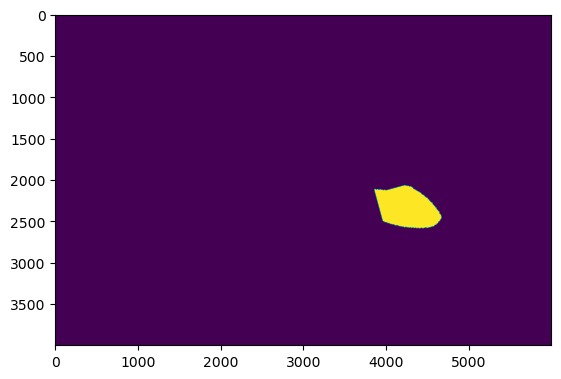

In [489]:
plt.imshow(rotated_mask_back)

230.0


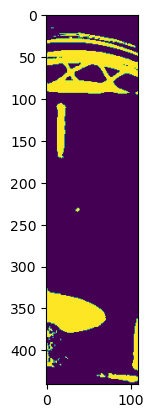

In [480]:
blurred_gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
print(np.median(blurred_gray))
if np.median(blurred_gray) < 200:
    thres = blurred_gray < np.median(blurred_gray)-25
else:
    thres = blurred_gray < np.median(blurred_gray)-15

if DEBUG:
    plt.figure()
    plt.imshow(thres)

In [457]:
glob(f'../WWBEE24_images/*/*/{date}/{bee_id}*'), date, bee_id, img_fp

([],
 '2024_06_20',
 'IMG-0016',
 '../2_live_bees/1_cards/2024_06_20_IMG-0016.png')

In [471]:
b = bee_id.replace('-','_')
glob(f'../WWBEE24_images/*/*/*/IMG*')

['../WWBEE24_images/Round02/hive15/2024_06_21/IMG_0036.JPG',
 '../WWBEE24_images/Round01/Hive03/2024_06_20/IMG_0016.JPG']

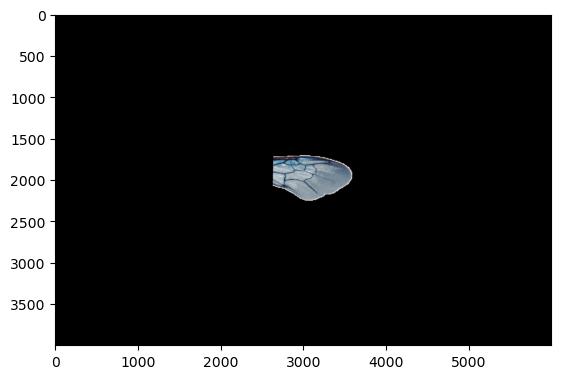

In [453]:
plt.imshow(original_seg)

In [438]:
img.shape

(4156, 1313, 3)

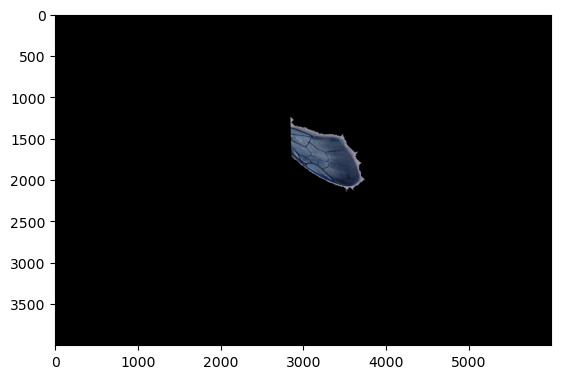

('../WWBEE24_images/Round01/Hive02/2024_06_10/h02b36.JPG',
 '2024_06_10',
 'h02b36',
 {'angle': -0.02617993877991498,
  'rotated_x_start': 2839,
  'rotated_x_end': 4152})

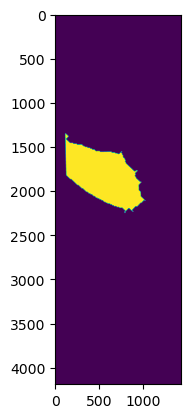

In [ ]:
#rotated_back = ndimage.rotate(original_mask, -metadata['angle']*180/np.pi, mode='constant', cval=0)
lr_pad = (rotated_mask_back.shape[1] - orig.shape[1]) // 2
ud_pad = (rotated_mask_back.shape[0] - orig.shape[0]) // 2

plt.imshow(rotated_back)
orig_fp, date, bee_id, metadata

In [424]:
rotated_back.shape, original_mask.shape, original_seg.shape, orig.shape

((4189, 1421), (4156, 1313), (4156, 1313, 3), (4000, 6000, 3))

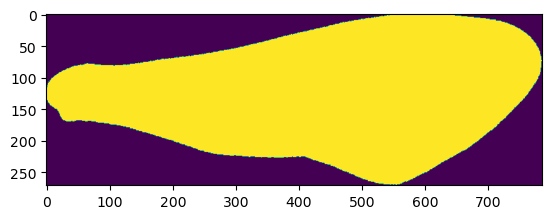

In [380]:
ref_mask = cv2.imread('../slides/type_mask_Hive01_Sheet_01_slide17_left.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(ref_mask)

In [394]:
closest_blob_mask.shape, scaled_img.shape

((416, 132), (308, 107, 3))

(351, 122)

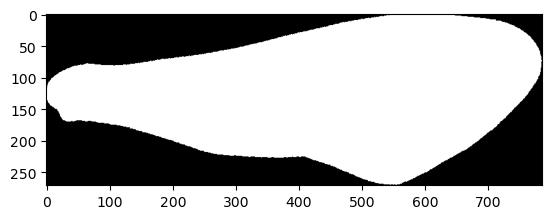

In [331]:
plt.imshow(closest_blob_seg)
plt.imsave('test.png', closest_blob_seg)

np.save('moving',closest_blob_mask)
a = cv2.imread('../slides/type_mask_Hive01_Sheet_01_slide17_left.png')
plt.imshow(a)
np.save('fixed',a[:,:,0])
closest_blob_mask.shape

(424, 143, 3)

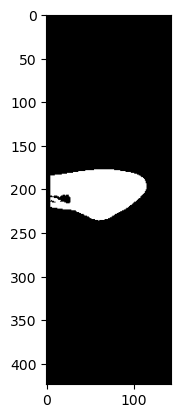

In [294]:
plt.imshow(np.pad(closest_blob_mask,((crop_top, crop_bott),(crop_left, crop_right),(0,0))))
np.pad(closest_blob_mask,((crop_top, crop_bott),(crop_left, crop_right),(0,0))).shape

 13%|█████████████████████▊                                                                                                                                                   | 4/31 [00:00<00:03,  7.15it/s]


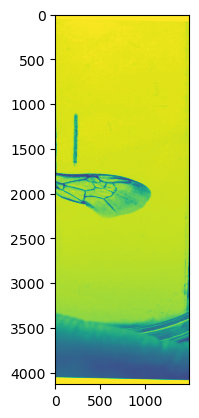

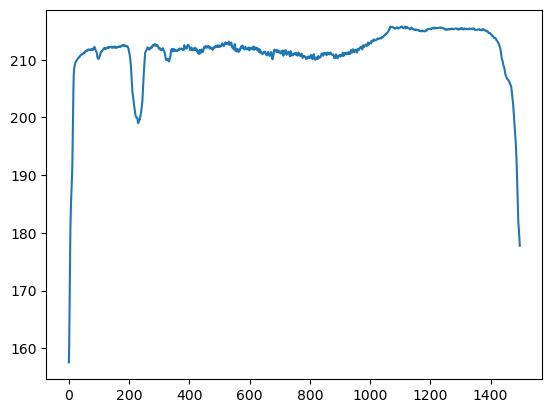

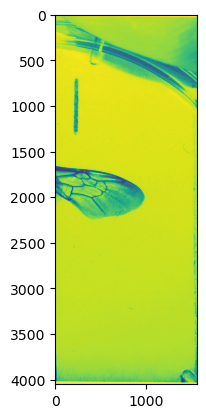

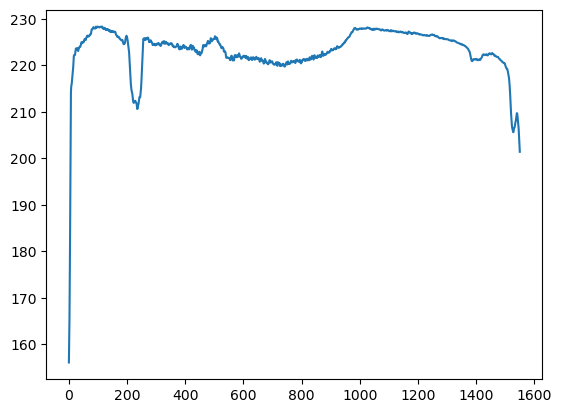

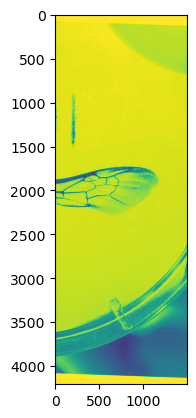

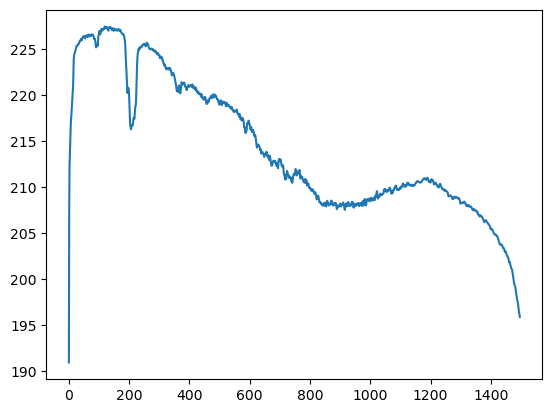

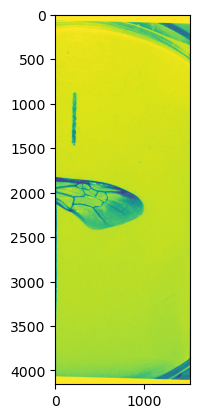

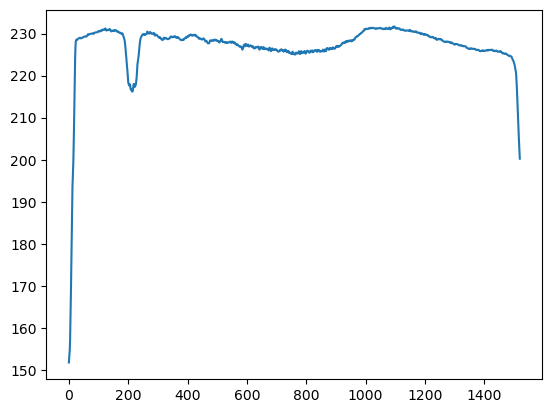

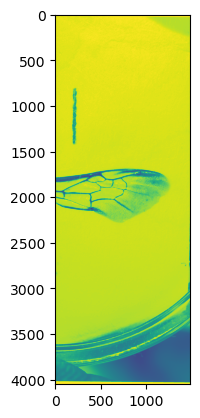

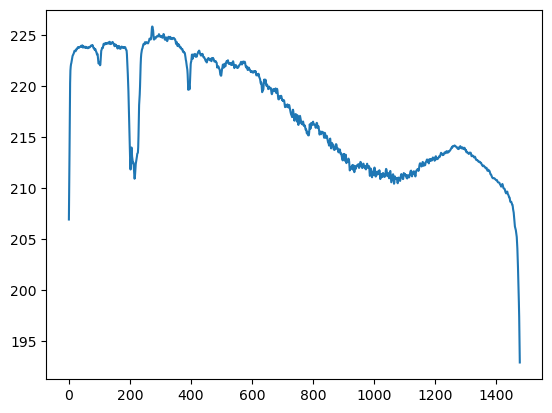

In [40]:
avg_intensities = []
img_fps = sorted(glob('../2_live_bees/1_cards/*'))
np.random.shuffle(img_fps)
i=0
for img_fp in tqdm(img_fps):
    
    img = cv2.imread(img_fp, cv2.IMREAD_GRAYSCALE)
    #plt.imshow(img)
    avg_intensities += [img.mean()]
    plt.figure()
    plt.imshow(img)
    plt.figure()
    plt.plot(img.mean(axis=0))
    i += 1
    if i == 5:
        break

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([165.67347875, 165.68347875, 165.69347875, 165.70347875,
        165.71347875, 165.72347875, 165.73347875, 165.74347875,
        165.75347875, 165.76347875, 165.77347875, 165.78347875,
        165.79347875, 165.80347875, 165.81347875, 165.82347875,
        165.83347875, 165.84347875, 165.85347875, 165.86347875,
        165.87347875, 165.88347875, 165.89347875, 165.90347875,
        165.91347875, 165.92347875, 165.93347875, 165.94347875,
        165.95347875, 165.96347875, 165.97347875, 165.98347875,
        165.99347875, 166.00347875, 16

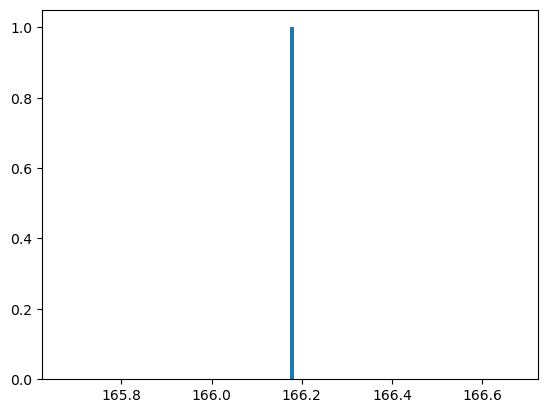

In [31]:
plt.hist(avg_intensities, bins=100)

In [32]:
len(img.mean(axis=0))

1500

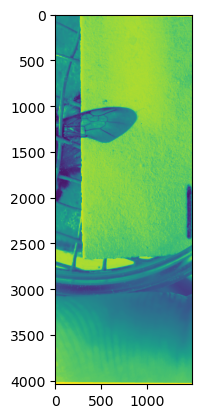

In [33]:
plt.imshow(img)

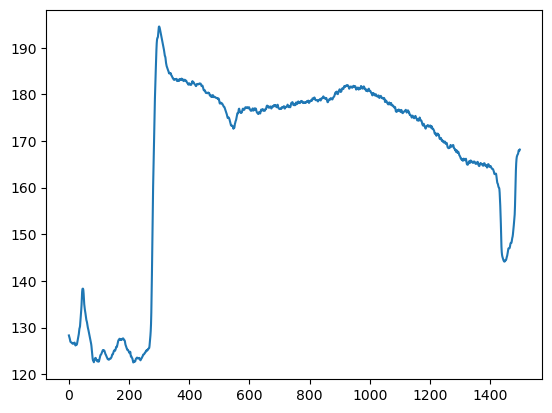